# Campaign Impact Analysis

The bank is currently struggling with low engagement from its marketing campaigns, even though they possess extensive customer data. Given this situation, the bank requires a marketing strategy that focuses on awareness campaigns: introducing the brand and products to as many new audiences as possible. Through analysis, we will derive actionable insights on how the existing marketing strategies can be improved.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
campaigns_df = pd.read_csv("../../data/processed/campaigns.csv")
customer_df = pd.read_csv("../../data/processed/customer.csv")
digital_usage_df = pd.read_csv("../../data/processed/digital_usage.csv")
engagement_details_df = pd.read_csv("../../data/processed/engagement_details.csv")
loans_df = pd.read_csv("../../data/processed/loans.csv")
products_owned_df = pd.read_csv("../../data/processed/products_owned.csv")
transactions_df = pd.read_csv("../../data/processed/transactions.csv")

print('Loaded Data Shapes:')
print('Campaign:', campaigns_df.shape)
print('Customer:', customer_df.shape)
print('DigitalUsage:', digital_usage_df.shape)
print('EngagementDetail:', engagement_details_df.shape)
print('Loan:', loans_df.shape)
print('ProductsOwned:', products_owned_df.shape)
print('Transaction:', transactions_df.shape)

Loaded Data Shapes:
Campaign: (99, 10)
Customer: (4000, 13)
DigitalUsage: (4000, 9)
EngagementDetail: (16000, 8)
Loan: (7920, 6)
ProductsOwned: (4000, 7)
Transaction: (5044, 5)


## Key Performance Indicators (KPI)

To effectively measure the success of our marketing campaigns and improve customer interactions, we have identified the following key performance indicators (KPIs):

1. Reach: This metric represents the number of unique customers who have been exposed to the campaign. It helps us understand the breadth of our campaign's audience and its potential impact.

2. Engagement Rate: This is the percentage of engagement attempts that result in a successful interaction with the customer. A higher engagement rate indicates that our campaign is resonating well with the audience and prompting them to take the desired action.

By focusing on these KPIs, we aim to gain actionable insights into the effectiveness of our marketing strategies and make data-driven decisions to enhance customer engagement.

### Reach

Are we using the right communication channels to the right customer demographics?

Is it better to employ a marketing strategy with a focused approach to campaigns or with diverse campaigns types?


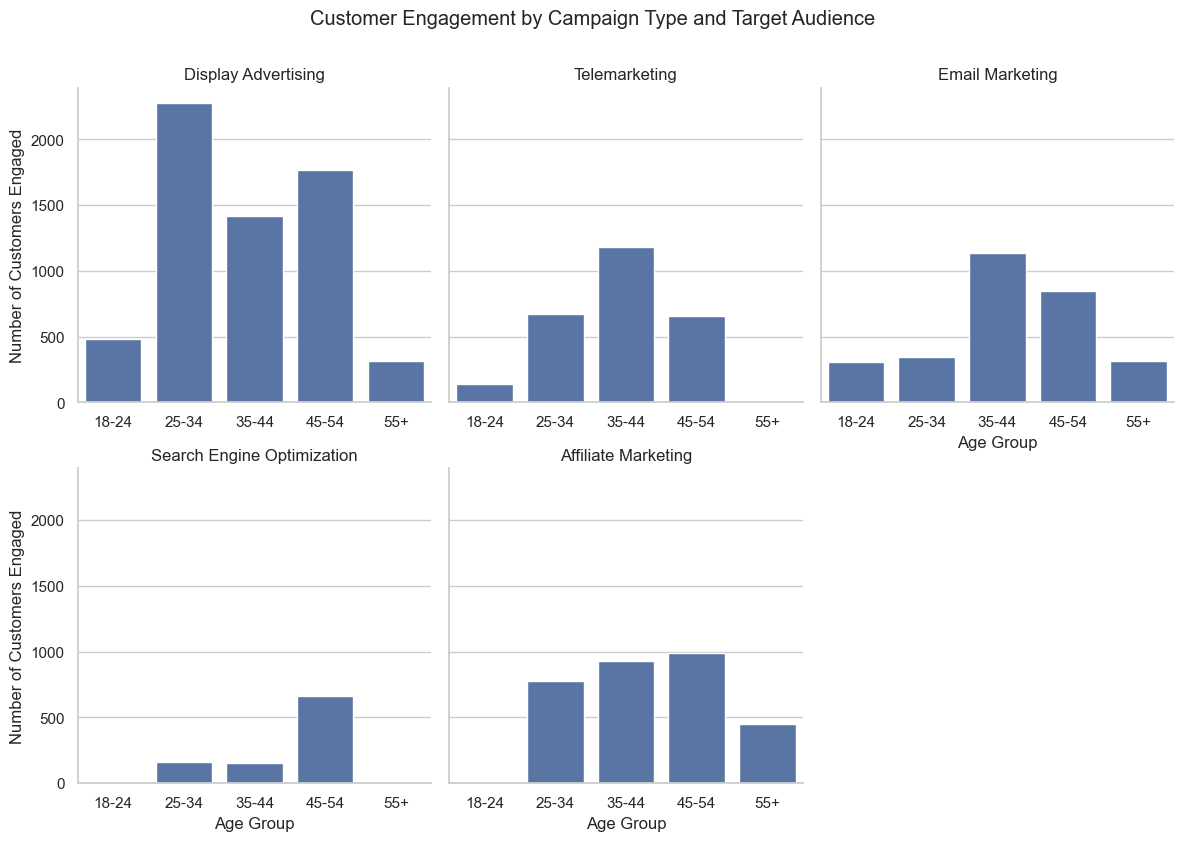

In [6]:
campaign_customers_df = engagement_details_df.merge(campaigns_df, on="campaign_id").merge(customer_df, on="customer_id")
g = sns.FacetGrid(campaign_customers_df, col="campaign_type", col_wrap=3, height=4, sharex=False)
g.map_dataframe(sns.countplot, x='target_audience', order=sorted(campaign_customers_df['target_audience'].unique()))
g.set_axis_labels('Age Group', 'Number of Customers Engaged')
g.set_titles(col_template='{col_name}')
g.figure.suptitle('Customer Engagement by Campaign Type and Target Audience', y=1.05)
plt.show()

In [7]:
campaign_customers_df[["target_audience", "age"]].head(10)

,target_audience,age
0,25-34,32
1,35-44,38
2,25-34,32
3,35-44,44
4,25-34,39
5,55+,35
6,35-44,27
7,25-34,37
8,25-34,32
9,45-54,29


In [8]:
# Define a function to check if age is within the target audience range
def is_age_in_target(row):
    age = row['age']
    target = row['target_audience']
    if target == '18-24':
        return 18 <= age <= 24
    elif target == '25-34':
        return 25 <= age <= 34
    elif target == '35-44':
        return 35 <= age <= 44
    elif target == '45-54':
        return 45 <= age <= 54
    elif target == '55+':
        return age >= 55
    else:
        return False

# Apply the function to create a new column
campaign_customers_df['age_in_target'] = campaign_customers_df.apply(is_age_in_target, axis=1)

# Group by campaign_id and count the number of rows where age_in_target is False
age_mismatch_rate = campaign_customers_df.groupby('campaign_id').apply(lambda x: (~x['age_in_target']).mean(), include_groups=False) * 100

print("Percentage mismatch between campaign target audience and actual engaged customer age:")
print(age_mismatch_rate)

Percentage mismatch between campaign target audience and actual engaged customer age:
campaign_id
1     76.875000
2     72.375691
3     91.082803
4     66.887417
5     72.352941
        ...    
95    71.515152
96    64.795918
97    77.647059
98    60.135135
99    77.472527
Length: 99, dtype: float64


At first glance, it seemed like we had a reasonable distribution of target audience for our campaigns. For example, digital campaigns focused more on younger potential customers, while telemarketing emphasized more on older audiences. However, upon further inspection, it turns out our engagement efforts did not align with the campaign goals, and between 60% to 90% of our engagements were targeted at the wrong intended age group.

--> Action: coordinate engagement efforts to focus on the target audience

**Now try and come up with other hypotheseses on how we could improve the marketing strategy but I haven't found much after quite a few experiments :(**

### Engagement rate:
- What portion of our engagements were successful?
- What are the characteristics of a campaign with high engagement rate?
- Which communication channels have a higher chance of customer interaction?
- Are we allocating our engagement efforts to the appropriate customer segments?

Overall Engagement Rate: 21.64%


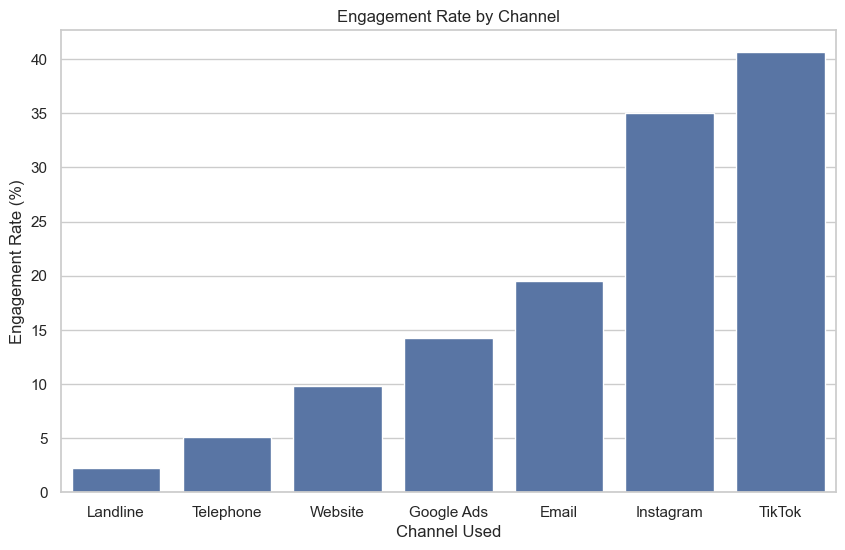

In [9]:
# Engagement rate overall
engagement_rate = engagement_details_df["has_engaged"].mean() * 100
print(f"Overall Engagement Rate: {engagement_rate:.2f}%")

# Engagement rate by communication channel used
engagement_campaign_df = engagement_details_df.merge(campaigns_df, on="campaign_id")
engagement_by_channel = engagement_campaign_df.groupby("channel_used")["has_engaged"].mean().sort_values() * 100

plt.figure(figsize=(10, 6))
sns.barplot(engagement_by_channel)
plt.title("Engagement Rate by Channel")
plt.xlabel("Channel Used")
plt.ylabel("Engagement Rate (%)")
plt.show()

It seems that while our average engagement rate is quite low at ~20%, this varies hugely by the channel used. Digital channels seem to perform better, especially social media platforms such as Tiktok and Instagram, which respond at ~40%, while tradional telemarketing has lower than 5% of success.

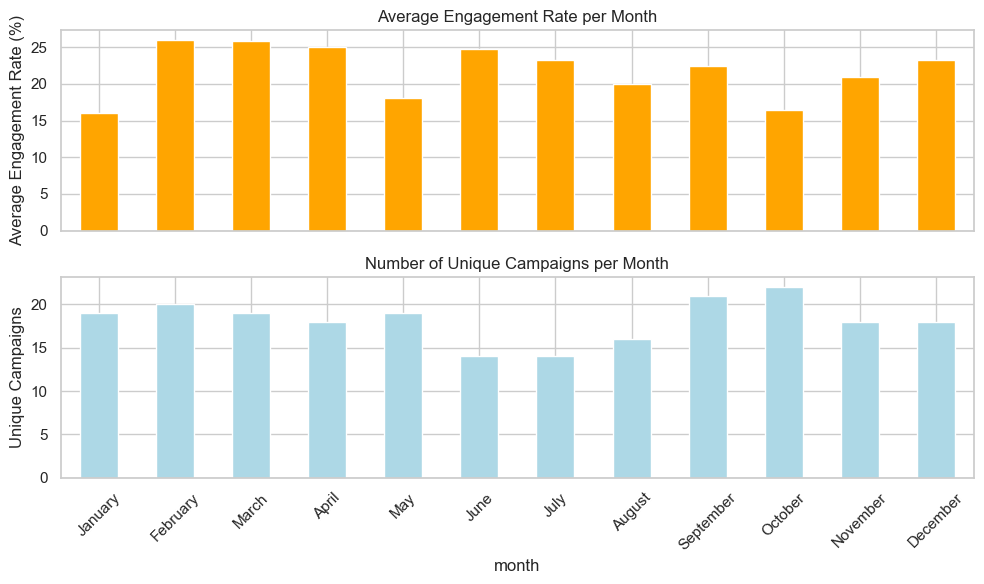

In [ ]:
campaign_customers_df["month"] = pd.Categorical(campaign_customers_df["month"], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
engagement_rate = campaign_customers_df.groupby("month", observed=True)["has_engaged"].mean() * 100
campaign_counts = campaign_customers_df.groupby("month", observed=True)["campaign_id"].nunique().sort_index()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

engagement_rate.plot(kind='bar', ax=ax1, color='orange')
ax1.set_title('Average Engagement Rate per Month')
ax1.set_ylabel('Average Engagement Rate (%)')
ax1.set_xlabel('Month')

campaign_counts.plot(kind='bar', ax=ax2, color='lightblue')
ax2.set_title('Number of Unique Campaigns per Month')
ax2.set_ylabel('Unique Campaigns')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Interestingly, June has the highest engagement rate, yet we run the fewest campaigns during this month. Conversely, October has the most campaigns but the lowest engagement rate. This suggests that we could improve our campaign scheduling.

--> Action: Shift more campaigns to periods of high engagement to maximize the engagement rate.

## Summary
- Key KPIs: Reach and engagement rate are critical metrics for evaluating the success of our marketing campaigns.
- Alignment: Ensure engagement efforts are consistent with campaign objectives.
- Seasonality: Consider the time of year when planning and organizing campaigns to optimize engagement.